This notebook contains the following:

1)	Importing libraries and data set.

2)	Analysing ‘payment type’ variable.

3)	Creating a new column.

4)	Visualising the new column’s data.

5)	Creating scatterplots and analysing results.

6)	Grouping data and checking trends (trip distance, payment type, fare amount) per NY boroughs.

7)	Visualisations of the abovementioned data.

8)	Dealing with missing data in the ‘borough’ column.


In [1]:
# Importing Analitycal and Visual libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import datetime 
import folium
import json
import plotly
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans 
import pylab as pl 

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

Creating a path to import and working on data set

In [3]:
# Establishing path
path = r'C:\Users\Paola\Desktop\Shaul\Data\CF\Data Immersion\Achievement 6\Uber October-2023 Basket Analysis'

In [4]:
# Following observations from previous notebooks, trip fare has been limited to $15 in order not to skew the data.

df = pd.read_csv(os.path.join(path, '2-Data', 'Prepared Data', 'uber_limited_to_usd15_trips.csv'), index_col = False)

In [5]:
df.shape

(75254, 29)

In [6]:
df.columns

Index(['VendorID', 'pickup_date', 'pickup_time', 'dropoff_date',
       'dropoff_time', 'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'Trip category',
       'Fare category', 'pickup_time_new', 'dropoff_time_new',
       'pickup_date_new', 'dropoff_date_new', 'geometry', 'Borough_name'],
      dtype='object')

Working on the 'payment tyoe' variable. I want to check if the fare to pay changes depending on the type of payment.

In [7]:
# Checking the values
# A numeric code signifying how the passenger paid for the trip.
# 1= Credit card
# 2= Cash
# 3= No charge
# 4= Dispute
# 5= Unknown
 #6= Voided trip
df['payment_type'].value_counts(dropna = False)

1    48770
2    26302
3      125
4       57
Name: payment_type, dtype: int64

Initial remarks:

65% of the trips were paid using a credit card. 
35% of the trips were paid using cash.
Only about 0.002% of trips resulted in no charge.
Only in about 0.0008% of trips there was a dispute between passenger/s and driver about the fare.

These last two observations are negligible from a statistical perspective, so only credit card and cash payments will be considered for the analysis.
There were no voided trips in this data set (after filtering the outliers).

Creating a 'payment category' variable

In [8]:
df.loc[df['payment_type'] == 1, 'payment_category'] = 'Card'

In [9]:
df.loc[df['payment_type'] == 2, 'payment_category'] = 'Cash'

In [10]:
df.loc[df['payment_type'] == 3, 'payment_category'] = 'No charge'

In [11]:
df.loc[df['payment_type'] == 4, 'payment_category'] = 'Dispute'

In [12]:
# Category variable succesfully created.
df['payment_category'].value_counts(dropna = False)

Card         48770
Cash         26302
No charge      125
Dispute         57
Name: payment_category, dtype: int64

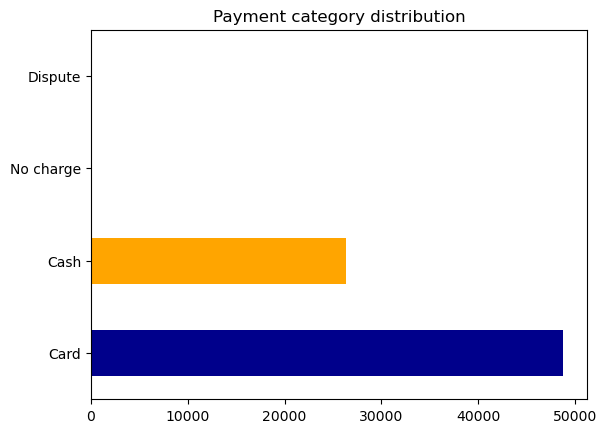

In [13]:
# Visualising the results.
# Making payment category bar chart.
# All visualisations are save to folder 4, in the graphs folders, using the right click.
bar = df['payment_category'].value_counts().plot.barh(color = ['darkblue', 'orange', 'cyan', 'salmon'], title='Payment category distribution')

For statistical purposes, the categories of 'no charge' and 'dispute' can be ignored.

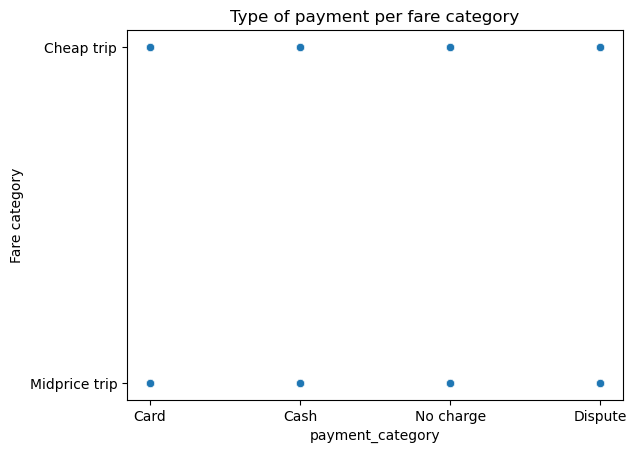

In [16]:
# Checking what type of payments are preferred depending on fare category.
# Attempting a Scatterpolot
scat = sns.scatterplot(x = 'payment_category', y = 'Fare category',data = df).set(title = 'Type of payment per fare category')

While ignoring the 'no charge' and 'dispute category', it seems that both types of payment are farily distributed between both cheap and midpriced trips.
It is worth mentioning that trips which are more expensive than $15 have been excluded, since they are the minority of the data. While it is definitely looking into those as well, the goal of this analysis is to find a pattern of use by the users, to inform price change decision-making by the stakeholders. In this context, these 'expensive' trips have been excluded.

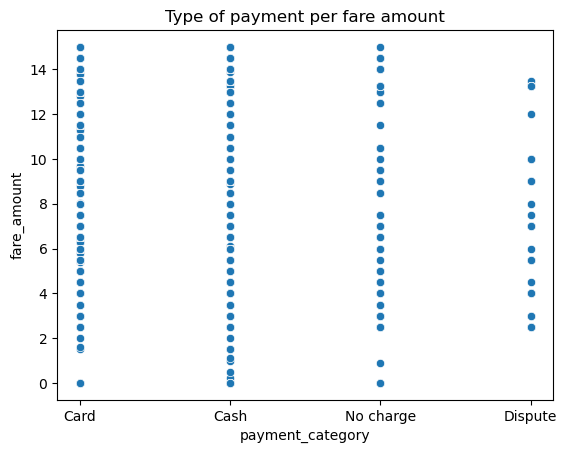

In [17]:
# Checking what type of payments are preferred depending on fare amount.
# Attempting a Scatterpolot
scat = sns.scatterplot(x = 'payment_category', y = 'fare_amount',data = df).set(title = 'Type of payment per fare amount')

This scatterplot seems to confirm the abovementioned conclusion.
While ignoring the 'no charge' and 'dispute category', it seems that both types of payment are farily distributed in the fare amount range. 
In a separately analysis, it would have been worth checking why some trips resulted in no charge or in dispute.

Checking the trend of distribution between cash and card peyments per borough

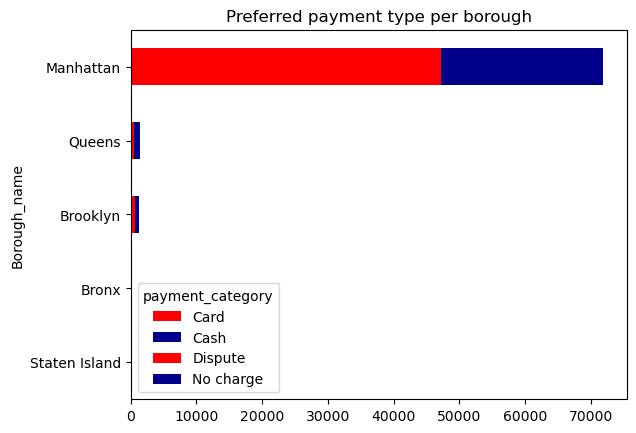

In [21]:
# Group payment type per boroughs.

df2 = df.groupby(['Borough_name', 'payment_category']).size().unstack()

# Sorting

df2 = df2.loc[df2.sum(axis=1).sort_values(ascending=True).index]

# Creating bar chart

bar1 = df2.plot.barh(stacked = True, title = 'Preferred payment type per borough', color = ['red','darkblue'])

In [22]:
# At first, I was confused with the values shown in this plot. 
# I decided to check the figures when the trip's fare was limited to $50, not just $15. 
# I see that figures were similar in that the vast majority of trips started in Manhattan. 
# The following are the values, when limiting the fare to $15.
df['Borough_name'].value_counts(dropna = False)

Manhattan        71833
Queens            1400
Brooklyn          1240
NaN                703
Bronx               76
Staten Island        2
Name: Borough_name, dtype: int64

These are the values when limiting the fare to $50.
Manhattan        89639
Queens            4614
Brooklyn          1836
NaN                917
Bronx               98
Staten Island        2

The missing values are negligible (they are 0.01% of the data) and will be dropped, as they do not affect the analysis. However, while there is a huge statistical differece between Manhattan and the other boroughs, so I will sublet to check the trend per borough. There is valuable insight to get in this analysis, even though statistically they are very different. 

In [23]:
# Creating a dataframe to find out the NaN entries
df_nan = df[df['Borough_name'].isnull() == True]

In [24]:
df_nan

,VendorID,pickup_date,pickup_time,dropoff_date,dropoff_time,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,total_amount,Trip category,Fare category,pickup_time_new,dropoff_time_new,pickup_date_new,dropoff_date_new,geometry,Borough_name,payment_category
62,2,01/03/2016 00:00,00:00:00,01/03/2016 00:00,00:09:00,1,0.73,-74.651306,40.609261,1,...,8.80,Short trip,Cheap trip,00:00:00,00:09:00,2016-03-01,2016-03-01,POINT (-74.65130615 40.60926056),NaN,Card
79,2,01/03/2016 00:00,00:00:00,01/03/2016 00:00,00:11:00,1,2.91,0.000000,0.000000,1,...,16.62,Short trip,Midprice trip,00:00:00,00:11:00,2016-03-01,2016-03-01,POINT (0 0),NaN,Card
327,2,10/03/2016 00:00,07:08:00,10/03/2016 00:00,07:09:00,6,0.02,0.000000,0.000000,1,...,3.30,Short trip,Cheap trip,07:08:00,07:09:00,2016-03-10,2016-03-10,POINT (0 0),NaN,Cash
368,2,10/03/2016 00:00,07:09:00,10/03/2016 00:00,07:17:00,5,1.73,0.000000,0.000000,1,...,10.56,Short trip,Cheap trip,07:09:00,07:17:00,2016-03-10,2016-03-10,POINT (0 0),NaN,Card
481,2,10/03/2016 00:00,07:10:00,10/03/2016 00:00,07:21:00,1,2.86,0.000000,0.000000,1,...,14.16,Short trip,Midprice trip,07:10:00,07:21:00,2016-03-10,2016-03-10,POINT (0 0),NaN,Card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74641,2,10/03/2016 00:00,14:24:00,10/03/2016 00:00,14:33:00,5,0.83,0.000000,0.000000,1,...,10.38,Short trip,Cheap trip,14:24:00,14:33:00,2016-03-10,2016-03-10,POINT (0 0),NaN,Card
74947,2,10/03/2016 00:00,14:27:00,10/03/2016 00:00,14:30:00,1,0.53,0.000000,0.000000,1,...,4.80,Short trip,Cheap trip,14:27:00,14:30:00,2016-03-10,2016-03-10,POINT (0 0),NaN,Cash
74964,1,01/03/2016 00:00,06:14:00,01/03/2016 00:00,06:18:00,1,0.80,0.000000,0.000000,1,...,7.30,Short trip,Cheap trip,06:14:00,06:18:00,2016-03-01,2016-03-01,POINT (0 0),NaN,Card
74972,1,01/03/2016 00:00,06:14:00,01/03/2016 00:00,06:21:00,1,2.60,0.000000,0.000000,1,...,10.30,Short trip,Cheap trip,06:14:00,06:21:00,2016-03-01,2016-03-01,POINT (0 0),NaN,Cash


In [25]:
# Creating a new dataframe without the missing values
dfclean = df[df['Borough_name'].isnull() == False]

In [26]:
dfclean['Borough_name'].value_counts(dropna = False)
# Missing values successfully dropped.

Manhattan        71833
Queens            1400
Brooklyn          1240
Bronx               76
Staten Island        2
Name: Borough_name, dtype: int64

Subsetting, to check if trend between cash and card is the same in all boroughs

In [27]:
man =  dfclean[dfclean['Borough_name']=='Manhattan']

In [28]:
man.shape

(71833, 30)

In [29]:
que =  dfclean[dfclean['Borough_name']=='Queens']

In [30]:
que.shape

(1400, 30)

In [31]:
brook =  dfclean[dfclean['Borough_name']=='Brooklyn']

In [32]:
brook.shape

(1240, 30)

In [33]:
bronx =  dfclean[dfclean['Borough_name']=='Bronx']

In [34]:
bronx.shape

(76, 30)

In [35]:
sisl =  dfclean[dfclean['Borough_name']=='Staten Island']

In [36]:
sisl.shape

(2, 30)

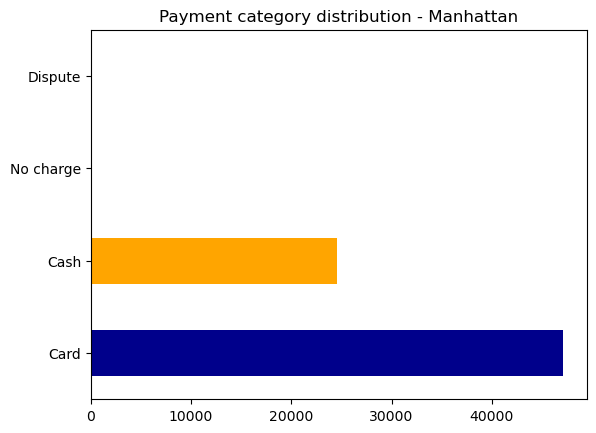

In [37]:
# Visualising the results => Manhattan.
# Making payment category bar chart.
# All visualisations are save to folder 4, in the graphs folders, using the right click.
bar01 = man['payment_category'].value_counts().plot.barh(color = ['darkblue', 'orange'], title='Payment category distribution - Manhattan')

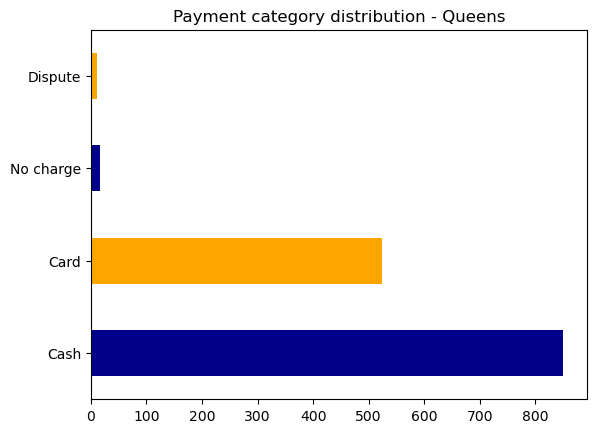

In [38]:
# Visualising the results => Queens.
# Making payment category bar chart.
# All visualisations are save to folder 4, in the graphs folders, using the right click.
bar01 = que['payment_category'].value_counts().plot.barh(color = ['darkblue', 'orange'], title='Payment category distribution - Queens')

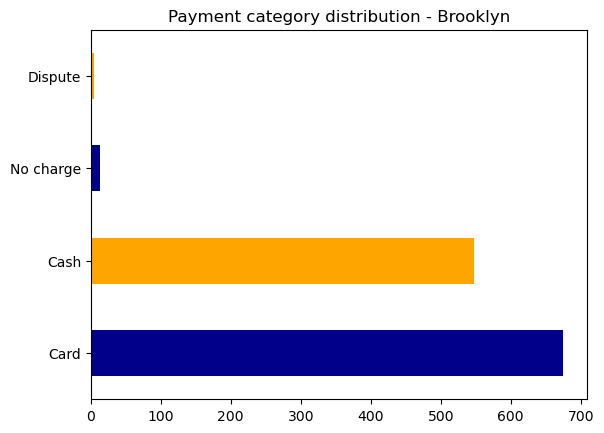

In [39]:
# Visualising the results => Brooklyn.
# Making payment category bar chart.
# All visualisations are save to folder 4, in the graphs folders, using the right click.
bar01 = brook['payment_category'].value_counts().plot.barh(color = ['darkblue', 'orange'], title='Payment category distribution - Brooklyn')

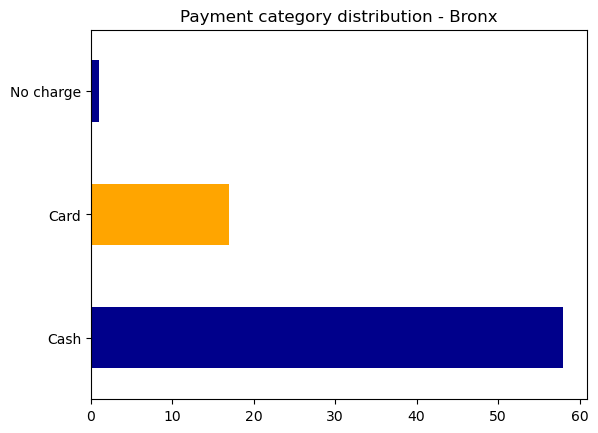

In [40]:
# Visualising the results => Bronx.
# Making payment category bar chart.
# All visualisations are save to folder 4, in the graphs folders, using the right click.
bar01 = bronx['payment_category'].value_counts().plot.barh(color = ['darkblue', 'orange'], title='Payment category distribution - Bronx')

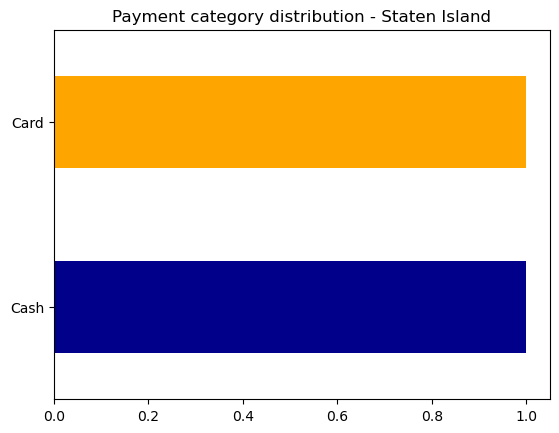

In [41]:
# Visualising the results => Staten Island.
# Making payment category bar chart.
# All visualisations are save to folder 4, in the graphs folders, using the right click.
bar01 = sisl['payment_category'].value_counts().plot.barh(color = ['darkblue', 'orange'], title='Payment category distribution - Staten Island')

The entries for Manhattan form the vast majority of the data for this dataset => 95%.
However, there is still valuable insight to be learned from what data is available in the other boroughs (excluding, perhaps, Staten Island).

NOTE: this implies a big limitation in this study, and I would check if the trends per borough remain similar with a bigger dataset.

In Manhattan, Card payment is preferred (66%) to cash payments (33%).
In Queens, cash payments are preferred (60%) over card payments (40%). This trend appears also in the Bronx, albeit with a considerable difference in percentage: 80% cash to 20% card.
In Brooklyn, there seems to be a fairly equal distribution between payments (55% card and 45% cash), with a difference of 10% preferring card payments.


Checking pattern per trip's distance

In [44]:
dfclean['Trip category'].value_counts(dropna = False)

Short trip     74534
Normal trip        9
Longer trip        8
Name: Trip category, dtype: int64

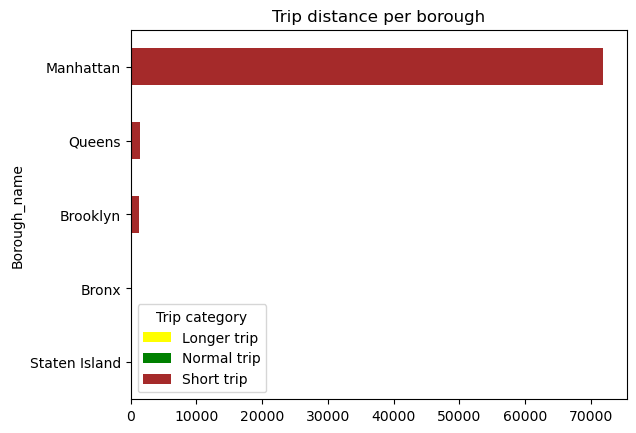

In [43]:
# Group trip categories per boroughs.

df3 = dfclean.groupby(['Borough_name', 'Trip category']).size().unstack()

# Sorting

df3 = df3.loc[df2.sum(axis=1).sort_values(ascending=True).index]

# Creating bar chart

bar2 = df3.plot.barh(stacked = True, title = 'Trip distance per borough', color = ['yellow','green', 'brown'])

The figures - before limiting the data to $15 - were as follows:
Short trip     84137
Normal trip     9372
Longer trip     3597

After limiting the data to $15, as maxmimum per trip, figures were as follows:
Short trip     74534
Normal trip        9
Longer trip        8

It seems that (most of) the missing values (703 in total) dropped earlier belonged to the normal or longer trips, as did the trips that costed between $16 and $50. This explains the reasons why only short trips are shown in all boroughs.

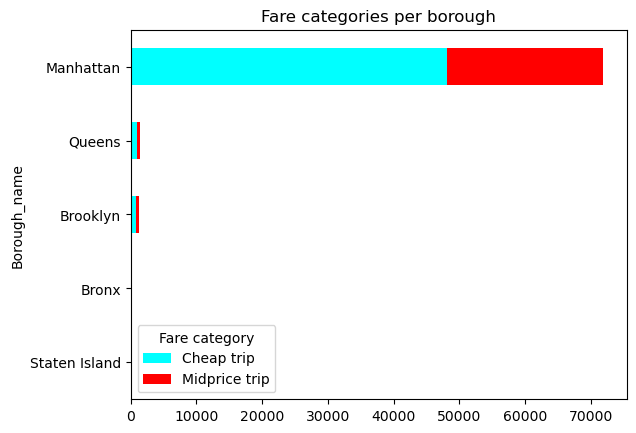

In [45]:
# Group fare categories per boroughs.

df4 = dfclean.groupby(['Borough_name', 'Fare category']).size().unstack()

# Sorting

df4 = df4.loc[df2.sum(axis=1).sort_values(ascending=True).index]

# Creating bar chart

bar3 = df4.plot.barh(stacked = True, title = 'Fare categories per borough', color = ['cyan','red', 'darkblue', 'salmon'])

In [47]:
# Checking this trend in the Bronx.
bronx['Fare category'].value_counts(dropna = False)

Cheap trip       54
Midprice trip    22
Name: Fare category, dtype: int64

From a statistical perspective, it seems that there is a pattern of 66% of trips being categorised as 'cheap' and about 33% of trips categorised as 'midprice'. Cheap trips are - proportionally - slightly higher in the Bronx (71%), although from a pattern perspective it could be argued that the pattern between cheap and midpriced trips is consistent in all boroughs, excluding Staten Island.

Exporting dataframe to file

In [48]:
# Exporting 'df' to csv
dfclean.to_csv(os.path.join(path, '2-Data','Prepared Data', 'uber_usd15_trips.csv'), index=False)